In [1]:
"""
Homework 4:

In this homework, you are to implement a bandit algorithm that solves the multi
armed bandit environment, and compare the performance between two different 
algorithms.
"""

"""
Xu Cao (xc2057)
"""

from __future__ import division

import time
import numpy as np


class Bandit:
    """
    Define a bandit class, which gives you an instance of the problem to solve.
    """
    def generate_reward(self, i):
        raise NotImplementedError

np.random.seed(42)

class BernoulliBandit(Bandit):

    def __init__(self, n, probs=None):
        assert probs is None or len(probs) == n
        self.n = n
        self.name = "Bernoulli Bandit"
        if probs is None:
            self.probs = [np.random.random() for _ in range(self.n)]
        else:
            self.probs = probs

        self.best_prob = max(self.probs)

    def generate_reward(self, i):
        # The player selected the i-th machine.
        if np.random.random() < self.probs[i]:
            return 1
        else:
            return 0


class GaussianBandit(Bandit):
    def __init__(self, n, probs=None):
        assert probs is None or len(probs) == n
        self.n = n
        self.name = "Gaussian Bandit"
        self.probs = [np.random.random() for _ in range(self.n)]
        self.variances = [(3*np.random.random() + 0.25) for _ in range(self.n)]

        self.best_prob = max(self.probs)

    def generate_reward(self, i):
        # The player selected the i-th machine.
        return np.random.normal(loc=self.probs[i], scale=self.variances[i])

In [2]:
class Solver(object):
    """
    Define a solver class, that you will have to subclass to solve this problem.

    Each of the algorithms you will implement will have the same format.
    """
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve.
        """
        assert isinstance(bandit, BernoulliBandit) or isinstance(bandit, GaussianBandit)

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # A list of machine ids, 0 to bandit.n-1.
        self.regret = 0.  # Cumulative regret.
        self.regrets = [0.]  # History of cumulative regret.

    def update_regret(self, i):
        # i (int): index of the selected machine.
        self.regret += self.bandit.best_prob - self.bandit.probs[i]
        self.regrets.append(self.regret)

    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)


class FullyRandom(Solver):
    """
    TODO: define the init function as well that initializes the superclass
    and defines the right class parameters.
    """
    def run_one_step(self):
        # TODO implement
        return np.random.randint(0, self.bandit.n)


class EpsilonGreedy(Solver):
    """
    TODO: define the init function as well that initializes the superclass
    and defines the right class parameters.
    """
    def __init__(self, bandit, epsilon=0.5):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.Q = [100.0 for i in range(self.bandit.n)]

    def run_one_step(self):
        # TODO implement
        if np.random.random() < self.epsilon:
          next_step = np.argmax(self.Q)
        else:
          next_step = np.random.randint(0, self.bandit.n)
        reward = self.bandit.generate_reward(next_step)
        self.Q[next_step] = self.Q[next_step] + 1/(self.counts[next_step]+1) * (reward - self.Q[next_step])
        return next_step


class UCBSolver(Solver):
    """
    TODO: define the init function as well that initializes the superclass
    and defines the right class parameters.
    """
    def __init__(self, bandit):
        super(UCBSolver, self).__init__(bandit)
        self.Q = [100.0 for i in range(self.bandit.n)]

    def __UCB(self):
        return np.sqrt(2 * np.log(sum(self.counts)+1) / (np.array(self.counts)+1))

    def run_one_step(self):
        # TODO implement
        next_step = np.argmax(self.Q + self.__UCB())
        reward = self.bandit.generate_reward(next_step)
        self.Q[next_step] = self.Q[next_step] + 1/(self.counts[next_step]+1) * (reward - self.Q[next_step])
        return next_step


class ThompsonSampling(Solver):
    """
    TODO: define the init function as well that initializes the superclass
    and defines the right class parameters.
    """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self.alpha = np.array([1.0 for i in range(self.bandit.n)])
        self.beta = np.array([1.0 for i in range(self.bandit.n)])

    def run_one_step(self):
        # TODO implement
        self.alpha[self.alpha <= 0] = 1.0
        self.beta[self.beta <= 0] = 1.0
        Q_bar = np.random.beta(self.alpha, self.beta)
        next_step = np.argmax(Q_bar)
        reward = self.bandit.generate_reward(next_step)
        update = np.zeros(self.bandit.n)
        update[next_step] = 1.0
        self.alpha = self.alpha + reward * update
        self.beta = self.beta + (1 - reward) * update

        return next_step

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

"""
TODO: Write a function that runs each of the multi-armed bandit agents on
each environments for 1e5 steps and plots the cumulative regret against number
of trials. Submit the plots with your writeup.
"""

STEP_NUM = 5000

def run_and_plot_all_algorithms(bandit):
    np.random.seed(42)
    # TODO Edit this
    FullyRandomModel = FullyRandom(bandit)
    EpsilonGreedyModel = EpsilonGreedy(bandit)
    UCBModel = UCBSolver(bandit)
    ThompsonSamplingModel = ThompsonSampling(bandit)
    FullyRandomModel.run(STEP_NUM)
    EpsilonGreedyModel.run(STEP_NUM)
    UCBModel.run(STEP_NUM)
    ThompsonSamplingModel.run(STEP_NUM)
    plt.plot(np.arange(STEP_NUM+1), FullyRandomModel.regrets)
    plt.plot(np.arange(STEP_NUM+1), EpsilonGreedyModel.regrets)
    plt.plot(np.arange(STEP_NUM+1), UCBModel.regrets)
    plt.plot(np.arange(STEP_NUM+1), ThompsonSamplingModel.regrets)
    plt.xlabel("Trial number")
    plt.ylabel("Cumulative Regret")
    plt.legend(["Fully Random", "Epsilon-Greedy", "UCB", "Thompson Sampling"])
    plt.title("Comparison plot for "+bandit.name)

# run_and_plot_all_algorithms()

Plot the Bernoulli bandit with 4 methods.

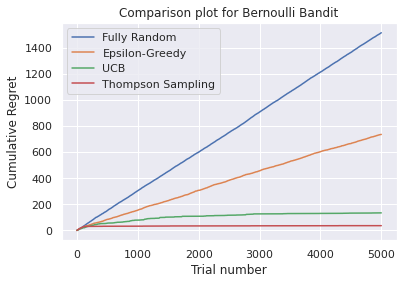

In [4]:
Bernoulli_bandit = BernoulliBandit(5, [1/8,1/2,1/8,1/8,1/8])
run_and_plot_all_algorithms(Bernoulli_bandit)

Plot the Gaussian bandit with 4 methods.

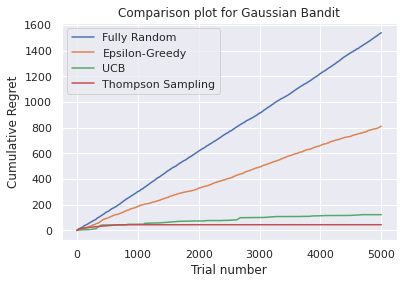

In [5]:
Gaussian_bandit = GaussianBandit(5, [1/8,1/2,1/8,1/8,1/8])
run_and_plot_all_algorithms(Gaussian_bandit)